In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

#Wavelet de ricker
def ricker(fp,dt,amostras):
    t0=6/(np.pi*fp*np.sqrt(2))
    tricker=np.arange(0,dt*(amostras),dt)
    rickeramp=(1-2*np.pi**2*fp**2*(tricker-t0)**2)*np.exp(-np.pi**2*fp**2*(tricker-t0)**2)
    return rickeramp

#interpolação sinc (Ver a descrição desse algoritmo acima na seção "Interpolação Sinc")
def sincint(y,dt,dtp):
    ffty=np.fft.rfft(y)#passo 1
    print((ffty.real**2 + ffty.imag**2).max())
    nf=int(round(y.size*dt/dtp))
    yp=np.zeros(nf//2+1,dtype=complex)#passo 2
    yp[0:ffty.size]=ffty#passo 3
    yp=np.fft.irfft(yp,nf)#passo 4
    return (dt/dtp)*yp#passo 5

def sincinttiro(y,dt,dtp):
    (amostras,nrecs)=np.shape(y)
    amostrasf=int(round(amostras*dt/dtp))
    saida=np.zeros((amostrasf,nrecs))
    for i in range(nrecs):
        saida[:,i]=sincint(y[:,i],dt,dtp)
    return saida

#estender modelo
def estendermodelo(vel,borda):
    (nz,nx)=np.shape(vel)
    nxa=nx+2*borda
    nza=nz+2*borda
    modelo=np.zeros((nza,nxa))
    modelo[borda:borda+nz,borda:borda+nx]=vel
    recheio=vel[:,0];
    for i in range(0,borda):
        modelo[borda:borda+nz,i]=recheio
    recheio=vel[:,nx-1]
    for i in range(borda+nx,nxa):
        modelo[borda:borda+nz,i]=recheio
    recheio=modelo[borda,:]
    for i in range(0,borda):
        modelo[i,:]=recheio
    recheio=modelo[borda+nz-1,:]
    for i in range(borda+nz,nza):
        modelo[i,:]=recheio
    return modelo

#taper para criar a borda absorvente
def taper(nz,nx,borda):
    damp=6.5*borda
    nxa=nx+2*borda
    nza=nz+2*borda
    amortece=np.ones((nza,nxa))
    for i in range(0,borda):
        amortece[i,:]=amortece[-1-i,:]=0.5*(1+np.cos(np.pi*(borda-i)/damp))
    for i in range(0,borda):
        amortece[:,i]=amortece[:,i]*0.5*(1+np.cos(np.pi*(borda-i)/damp))
        amortece[:,-1-i]=amortece[:,-1-i]*0.5*(1+np.cos(np.pi*(borda-i)/damp))
    return amortece

#cálculo do laplaciano
def laplaciano(onda,dx,dz):
    dp_dzz=(-np.roll(onda,2,axis=0)+16*np.roll(onda,1,axis=0)+16*np.roll(onda,-1,axis=0)-\
            np.roll(onda,-2,axis=0)-30*onda)/(12.0*dz**2) #cálculo da segunda derivada em z
    dp_dzz[0,:]=dp_dzz[1,:]=(onda[0,:]-2*onda[1,:]+onda[2,:])/(dz**2)#cálculo da segunda derivada em z para as duas primeiras linhas
    dp_dzz[-1,:]=dp_dzz[-2,:]=(onda[-1,:]-2*onda[-2,:]+onda[-3,:])/(dz**2)#cálculo da segunda derivada em z para as duas últimas linhas
    dp_dxx=(-np.roll(onda,2,axis=1)+16*np.roll(onda,1,axis=1)+\
            16*np.roll(onda,-1,axis=1)-np.roll(onda,-2,axis=1)-30*onda)/(12.0*dx**2)#cálculo da segunda derivada em x
    dp_dxx[:,0]=dp_dxx[:,1]=(onda[:,0]-2*onda[:,1]+onda[:,2])/(dx**2)#cálculo da segunda derivada em z para as duas primeiras colunas
    dp_dxx[:,-1]=dp_dxx[:,-2]=(onda[:,-1]-2*onda[:,-2]+onda[:,-3])/(dx**2)#cálculo da segunda derivada em z para as duas últimas colunas
    return dp_dxx+dp_dzz

#propagador
def propagador(wavelet,dt,amostras,soux,souz,recx,recz,vel,dx,dz,borda):
    velmax=vel.max()
    dtp=dt
    reamos=1
    hefec=1/np.sqrt(dx**-2 + dz**-2)
    cfl=np.sqrt(0.75)*hefec/velmax
    while dtp>cfl:
        reamos+=1
        dtp=dt/reamos #Cálculo do dtp de propagação apartir do dt de amostragem
    print('A razão dt/dtp é',reamos,'sendo dt=',dt*1000,'ms e dtp=',dtp*1000,'ms')
    amostrasr=amostras*reamos #como diminiu o dtp então devem ser aumentadas as amostras para manter o tempo total
    wavelet1=sincint(wavelet,dt,dtp)#deve-se interpolar a wavelet
    (nz,nx)=np.shape(vel)
    nxa=nx+2*borda
    nza=nz+2*borda
    vel1=estendermodelo(vel,borda)
    amortecedor=taper(nz,nx,borda)
    onda0=np.zeros((nza,nxa))
    onda1=np.zeros((nza,nxa))
    onda2=np.zeros((nza,nxa))
    nrecs=recx.size
    tiro=np.zeros((amostras,nrecs))
    con=(vel1*dtp)**2
    ta=0
    for t in range(amostrasr):
        onda2=2*onda1-onda0+con*laplaciano(onda1,dx,dz)
        onda2[souz+borda,soux+borda]=onda2[souz+borda,soux+borda]+con[souz+borda,soux+borda]*wavelet1[t]/(dx*dz)
        if t%reamos==0:
            for j in range(nrecs):
                tiro[ta,j]=onda2[recz[j]+borda,recx[j]+borda]
            ta=ta+1
            
        onda0=onda1*amortecedor
        onda1=onda2*amortecedor
    return tiro

In [5]:
def sincint2(y,dt,dtp):
    ffty=np.fft.rfft(y)#passo 1
    
    #print((ffty.real**2 + ffty.imag**2).mean())
    #plt.plot(ffty.real**2 + ffty.imag**2)
    
    nf=int(round(y.size*dt/dtp))
    yp=np.zeros(nf//2+1,dtype=complex)#passo 2
    yp[0:ffty.size]=ffty#passo 3
    
    #print((yp.real**2 + yp.imag**2).mean())
    
    yp=np.fft.irfft(yp,nf)#passo 4
    
    #print((yp**2 ).mean())
    #print((yp**2 ).max())
    print((yp*dt/dtp).mean())
    print((y).mean())
    
    return (dt/dtp)*yp#passo 5


In [6]:
#parametros
dt=0.01
amostras=300
nx=251
nz=201
dx=20
dz=20
f=10.0
wavelet=ricker(f,dt,amostras)
borda=50
vel=np.ones((nz,nx))*3000
vel[nz//2:nz,:]=5500
souz=1
soux=nx//2
recx=np.arange(0,nx,4)
recz=np.ones(recx.size,dtype='int')*2
sordem=4//2 #metade da ordem do laplaciano
instante=100 #instante para visualizar o campo

In [7]:
velmax=vel.max()
dtp=dt
reamos=1
hefec=1/np.sqrt(dx**-2 + dz**-2)
cfl=np.sqrt(0.75)*hefec/velmax
while dtp>cfl:
    reamos+=1
    dtp=dt/reamos
print('A razão dt/dtp é',reamos,'sendo dt=',dt*1000,'ms e dtp=',dtp*1000,'ms')
amostrasr=amostras*reamos 
wavelet1=sincint(wavelet,dt,dtp)
(nz,nx)=np.shape(vel)
nxa=nx+2*borda
nza=nz+2*borda
vel1=estendermodelo(vel,borda)
amortecedor=taper(nz,nx,borda)
onda0=np.zeros((nza,nxa))
onda1=np.zeros((nza,nxa))
onda2=np.zeros((nza,nxa))
nrecs=recx.size
tirod=np.zeros((amostras,nrecs))#tiro simulado com o campo direto
tiror=np.zeros((amostras,nrecs))#tiro simulado com o campo reconstruido
con=(vel1*dtp)**2
campod=np.zeros((nz,nx)) 
campor=np.zeros((nz,nx)) 
tampaxl=np.zeros((amostrasr,nz,sordem));tampaxr=np.zeros((amostrasr,nz,sordem))
tampazl=np.zeros((amostrasr,sordem,nx));tampazr=np.zeros((amostrasr,sordem,nx))

ta=0
for t in range(amostrasr):
    onda2=2*onda1-onda0+con*laplaciano(onda1,dx,dz)
    onda2[souz+borda,soux+borda]=onda2[souz+borda,soux+borda]+con[souz+borda,soux+borda]*wavelet1[t]/(dx*dz)
    tampaxl[t,:,:]=onda1[borda:borda+nz,borda:borda+sordem]
    tampaxr[t,:,:]=onda1[borda:borda+nz,borda+nx-sordem:borda+nx]
    tampazl[t,:,:]=onda1[borda:borda+sordem,borda:borda+nx]
    tampazr[t,:,:]=onda1[borda+nz-sordem:borda+nz,borda:borda+nx]
    if t%reamos==0:
        for j in range(nrecs):#aqui gravado o tiro simulado
            tirod[ta,j]=onda1[recz[j]+borda,recx[j]+borda]
        ta=ta+1
    if t==instante*reamos:#aqui é capturado o campo de onda
        campod[:,:]=onda1[borda:borda+nz,borda:borda+nx]
    if t!=amostrasr-1:
        onda0=onda1*amortecedor
        onda1=onda2*amortecedor
    else:
        onda0[:,:]=onda2[:,:]
        
ta=amostras-1       
for t in range(amostrasr-1,-1,-1): 
    onda1[borda:borda+nz,borda:borda+sordem]=tampaxl[t,:,:]
    onda1[borda:borda+nz,borda+nx-sordem:borda+nx]=tampaxr[t,:,:]
    onda1[borda:borda+sordem,borda:borda+nx]=tampazl[t,:,:]
    onda1[borda+nz-sordem:borda+nz,borda:borda+nx]=tampazr[t,:,:]
    onda2=2*onda1-onda0+con*laplaciano(onda1,dx,dz)
    onda2[souz+borda,soux+borda]=onda2[souz+borda,soux+borda]+con[souz+borda,soux+borda]*wavelet1[t]/(dx*dz)
    if t%reamos==0:
        for j in range(nrecs):
            tiror[ta,j]=onda1[recz[j]+borda,recx[j]+borda]
        ta=ta-1
    if t==instante*reamos:
        campor[:,:]=onda1[borda:borda+nz,borda:borda+nx]
    onda0=onda1*amortecedor
    onda1=onda2*amortecedor


A razão dt/dtp é 5 sendo dt= 10.0 ms e dtp= 2.0 ms
17.23142311535007


In [8]:
print(campod.max())

0.047898455734498836


In [9]:
print(wavelet.max())

0.9288248019261793


Text(0.5, 1.0, 'Diferença')

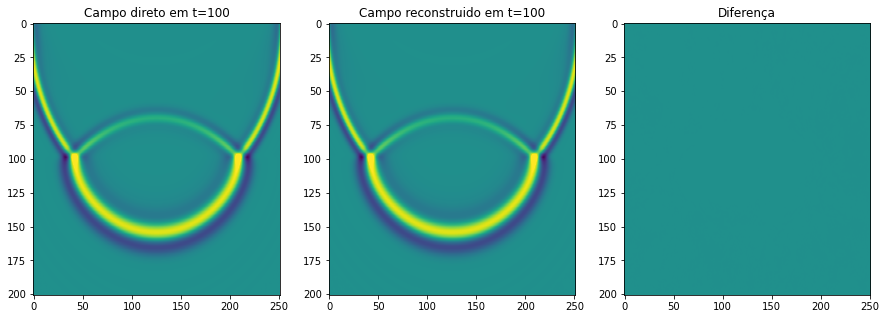

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(campod,aspect='auto');plt.clim(-0.03,0.03)
plt.title('Campo direto em t='+str(instante))
plt.subplot(132)
plt.imshow(campor,aspect='auto');plt.clim(-0.03,0.03)
plt.title('Campo reconstruido em t='+str(instante))
plt.subplot(133)
plt.imshow(campod-campor,aspect='auto');plt.clim(-0.03,0.03)
plt.title('Diferença')

In [22]:
print((campod**2).mean())
print((campor**2).mean())
print(((campod-campor)**2).mean())
print((campod**2).mean() - (campor**2).mean())

4.747899343469608e-05
4.747899343469607e-05
1.5662405126924718e-34
6.776263578034403e-21


Text(0.5, 1.0, 'Diferença')

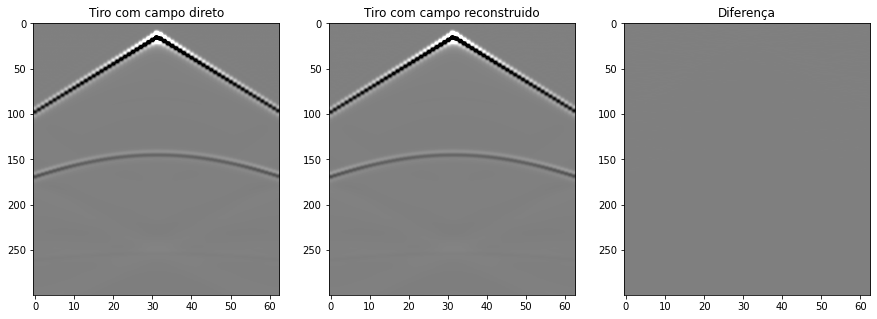

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(tirod,aspect='auto',cmap='binary');plt.clim(-0.03,0.03)
plt.title('Tiro com campo direto')
plt.subplot(132)
plt.imshow(tiror,aspect='auto',cmap='binary');plt.clim(-0.03,0.03)
plt.title('Tiro com campo reconstruido')
plt.subplot(133)
plt.imshow(tirod-tiror,aspect='auto',cmap='binary');plt.clim(-0.03,0.03)
plt.title('Diferença')


In [21]:
print((tirod**2).mean())
print((tiror**2).mean())
print(((tirod-tiror)**2).mean())
print((tirod**2).mean() - (tiror**2).mean())

4.2581919910146604e-05
4.25819199101466e-05
1.1022968051540484e-34
6.776263578034403e-21


In [13]:
#avaliação de memória usada nos dois métodos
mem1=(tampaxl.size+tampaxr.size+tampazl.size+tampazr.size)*8/1024/1024
mem2=nz*nx*amostras*8/1024/1024
print('Memória do método convencional = ',mem2,' Mb')
print('Memória do método reconstruido = ',mem1,' Mb')

Memória do método convencional =  115.47317504882812  Mb
Memória do método reconstruido =  20.69091796875  Mb


In [14]:
# gradiente método convencional 
def gradiente(wavelet,dt,amostras,soux,souz,recx,recz,vel,dx,dz,borda,tiro):
    velmax=vel.max()
    dtp=dt
    reamos=1
    hefec=1/np.sqrt(dx**-2 + dz**-2)
    cfl=np.sqrt(0.75)*hefec/velmax
    while dtp>cfl:
        reamos+=1
        dtp=dt/reamos #Cálculo do dtp de propagação apartir do dt de amostragem
    print('A razão dt/dtp é',reamos,'sendo dt=',dt*1000,'ms e dtp=',dtp*1000,'ms')
    amostrasr=amostras*reamos #como diminiu o dtp então devem ser aumentadas as amostras para manter o tempo total
    wavelet1=sincint(wavelet,dt,dtp)#deve-se interpolar a wavelet
    (nz,nx)=np.shape(vel)
    nxa=nx+2*borda
    nza=nz+2*borda
    vel1=estendermodelo(vel,borda)
    amortecedor=taper(nz,nx,borda)
    onda0=np.zeros((nza,nxa))
    onda1=np.zeros((nza,nxa))
    onda2=np.zeros((nza,nxa))
    campo=np.zeros((nz,nx,amostras))
    nrecs=recx.size
    desajuste=np.zeros((amostras,nrecs))
    con=(vel1*dtp)**2
    ta=0
    for t in range(amostrasr):
        onda2=2*onda1-onda0+con*laplaciano(onda1,dx,dz)
        onda2[souz+borda,soux+borda]=onda2[souz+borda,soux+borda]+con[souz+borda,soux+borda]*wavelet1[t]/(dx*dz)
        if t%reamos==0:
            campo[:,:,ta]=(onda2[borda:borda+nz,borda:borda+nx]-2*onda1[borda:borda+nz,borda:borda+nx]+onda0[borda:borda+nz,borda:borda+nx])/dtp**2
            for j in range(nrecs):
                desajuste[ta,j]=onda2[recz[j]+borda,recx[j]+borda]-tiro[ta,j]
            ta=ta+1
        onda0=onda1*amortecedor
        onda1=onda2*amortecedor
    custo=(0.5*desajuste**2).sum()
    desajuste=sincinttiro(desajuste,dt,dtp)
    onda0[:,:]=0;onda1[:,:]=0;onda2[:,:]=0;
    ta=amostras-1
    for t in range(amostrasr-1,-1,-1):
        onda2=2*onda1-onda0+con*laplaciano(onda1,dx,dz)
        for j in range(nrecs):
            onda2[recz[j]+borda,recx[j]+borda]=onda2[recz[j]+borda,recx[j]+borda]+con[borda+recz[j],borda+recx[j]]*desajuste[t,j]
        if t%reamos==0:
            campo[:,:,ta]=campo[:,:,ta]*onda1[borda:borda+nz,borda:borda+nx]
            ta=ta-1
        onda0=onda1*amortecedor
        onda1=onda2*amortecedor
    grad=-np.sum(campo,axis=2)  
    return grad,custo

# gradiente método reconstruido
def gradiente_recon(wavelet,dt,amostras,soux,souz,recx,recz,vel,dx,dz,borda,tiro):
    velmax=vel.max()
    dtp=dt
    reamos=1
    hefec=1/np.sqrt(dx**-2 + dz**-2)
    cfl=np.sqrt(0.75)*hefec/velmax
    sordem=2
    while dtp>cfl:
        reamos+=1
        dtp=dt/reamos #Cálculo do dtp de propagação apartir do dt de amostragem
    print('A razão dt/dtp é',reamos,'sendo dt=',dt*1000,'ms e dtp=',dtp*1000,'ms')
    amostrasr=amostras*reamos #como diminiu o dtp então devem ser aumentadas as amostras para manter o tempo total
    wavelet1=sincint(wavelet,dt,dtp)#deve-se interpolar a wavelet
    (nz,nx)=np.shape(vel)
    nxa=nx+2*borda
    nza=nz+2*borda
    vel1=estendermodelo(vel,borda)
    amortecedor=taper(nz,nx,borda)
    onda0=np.zeros((nza,nxa))
    onda1=np.zeros((nza,nxa))
    onda2=np.zeros((nza,nxa))
    grad=np.zeros((nz,nx))
    tampaxl=np.zeros((amostrasr,nz,sordem));tampaxr=np.zeros((amostrasr,nz,sordem))
    tampazl=np.zeros((amostrasr,sordem,nx));tampazr=np.zeros((amostrasr,sordem,nx))
    nrecs=recx.size
    desajuste=np.zeros((amostras,nrecs))
    con=(vel1*dtp)**2
    ta=0
    for t in range(amostrasr):
        onda2=2*onda1-onda0+con*laplaciano(onda1,dx,dz)
        onda2[souz+borda,soux+borda]+=con[souz+borda,soux+borda]*wavelet1[t]/(dx*dz)
        tampaxl[t,:,:]=onda1[borda:borda+nz,borda:borda+sordem]
        tampaxr[t,:,:]=onda1[borda:borda+nz,borda+nx-sordem:borda+nx]
        tampazl[t,:,:]=onda1[borda:borda+sordem,borda:borda+nx]
        tampazr[t,:,:]=onda1[borda+nz-sordem:borda+nz,borda:borda+nx]
        if t%reamos==0:
            for j in range(nrecs):
                desajuste[ta,j]=onda2[recz[j]+borda,recx[j]+borda]-tiro[ta,j]
            ta=ta+1 
        if t!=amostrasr-1:
            onda0=onda1*amortecedor
            onda1=onda2*amortecedor
        else:
            onda0[:,:]=onda2[:,:]
    
    custo=(0.5*desajuste**2).sum()
    desajuste=sincinttiro(desajuste,dt,dtp)
    onda0[:,:]=0.0
    onda1[:,:]=0.0
    onda2[:,:]=0.0
    onda0r=np.zeros((nza,nxa))
    onda1r=np.zeros((nza,nxa))
    onda2r=np.zeros((nza,nxa))
    ta=amostras-1
    for t in range(amostrasr-1,-1,-1):
        onda1[borda:borda+nz,borda:borda+sordem]=tampaxl[t,:,:]
        onda1[borda:borda+nz,borda+nx-sordem:borda+nx]=tampaxr[t,:,:]
        onda1[borda:borda+sordem,borda:borda+nx]=tampazl[t,:,:]
        onda1[borda+nz-sordem:borda+nz,borda:borda+nx]=tampazr[t,:,:]#recuperaçao do campo de onda apartir das bordas
        onda2=2*onda1-onda0+con*laplaciano(onda1,dx,dz)
        onda2[souz+borda,soux+borda]=onda2[souz+borda,soux+borda]+con[souz+borda,soux+borda]*wavelet1[t]/(dx*dz)
        onda2r=2*onda1r-onda0r+con*laplaciano(onda1r,dx,dz)
        for j in range(nrecs):
            onda2r[recz[j]+borda,recx[j]+borda]=onda2r[recz[j]+borda,recx[j]+borda]+con[borda+recz[j],borda+recx[j]]*desajuste[t,j]
        if t%reamos==0:
            d2u=(onda2[borda:borda+nz,borda:borda+nx]-2*onda1[borda:borda+nz,borda:borda+nx]+onda0[borda:borda+nz,borda:borda+nx])/dtp**2
            grad-=d2u*onda1r[borda:borda+nz,borda:borda+nx]
        onda0=onda1*amortecedor
        onda1=onda2*amortecedor
        onda0r=onda1r*amortecedor
        onda1r=onda2r*amortecedor
    return grad,custo

In [15]:
dt=0.01
amostras=300
nx=251
nz=201
dx=20
dz=20
f=10.0
wavelet=ricker(f,dt,amostras)
borda=50
vel=np.ones((nz,nx))*3000
vel0=np.ones((nz,nx))*3000
vel0[nz//2:nz,:]=4500
souz=1
soux=nx//2
recx=np.array([nx//15,14*nx//15])
recz=np.ones(recx.size,dtype='int')*2

In [16]:
#simulação de dado observado
tic=time.time()
tiro=propagador(wavelet,dt,amostras,soux,souz,recx,recz,vel,dx,dz,borda)
toc=time.time()
print('Demorei ',toc-tic,' segundos')

A razão dt/dtp é 3 sendo dt= 10.0 ms e dtp= 3.3333333333333335 ms
17.23142311535007
Demorei  4.148350477218628  segundos


In [17]:
#Gradiente pelo método convencional
tic=time.time()
grad1,custo1=gradiente(wavelet,dt,amostras,soux,souz,recx,recz,vel0,dx,dz,borda,tiro)
toc=time.time()
print('Demorei ',toc-tic,' segundos')
print('A funçao custo é ',custo1)

A razão dt/dtp é 4 sendo dt= 10.0 ms e dtp= 2.5 ms
17.23142311535007
0.0011481841987201634
0.0011481841987201645
Demorei  8.774115562438965  segundos
A funçao custo é  0.00015883911348360668


In [18]:
#Gradiente pelo método de reconstrução
tic=time.time()
grad2,custo2=gradiente_recon(wavelet,dt,amostras,soux,souz,recx,recz,vel0,dx,dz,borda,tiro)
toc=time.time()
print('Demorei ',toc-tic,' segundos')
print('A funçao custo é ',custo2)

A razão dt/dtp é 4 sendo dt= 10.0 ms e dtp= 2.5 ms
17.23142311535007
0.0011481841987201634
0.0011481841987201645
Demorei  10.094612836837769  segundos
A funçao custo é  0.00015883911348360668


Text(0.5, 1.0, 'Diferença')

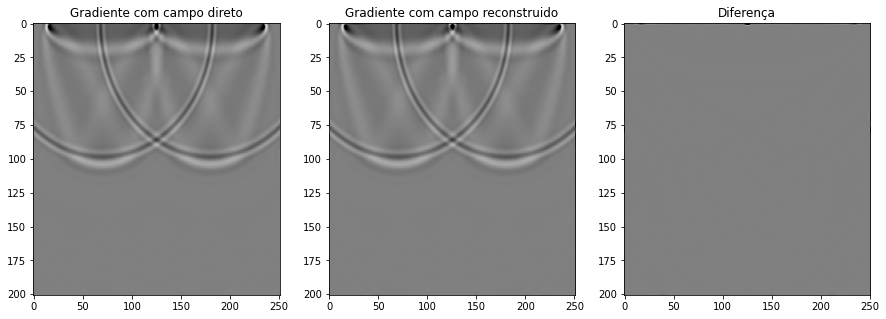

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(grad1,aspect='auto',cmap='binary');plt.clim(-100,100)
plt.title('Gradiente com campo direto')
plt.subplot(132)
plt.imshow(grad2,aspect='auto',cmap='binary');plt.clim(-100,100)
plt.title('Gradiente com campo reconstruido')
plt.subplot(133)
plt.imshow(grad1-grad2,aspect='auto',cmap='binary');plt.clim(-100,100)
plt.title('Diferença')